In [7]:
# Import libraries and packages

import numpy as np
import pandas as pd
from pandas.api.types import is_string_dtype
from pandas.api.types import is_numeric_dtype
import seaborn as sns
import matplotlib.pyplot as plt
import csv
import json
import geojson
import folium
from folium import plugins
from folium.plugins import FastMarkerCluster
from folium.plugins import TimestampedGeoJson
import datetime
import geopandas as gpd
import geoplot
import geoplot.crs as gcrs
import geoplot as gplt

%matplotlib inline

In [8]:
ls Airbnb_Japan/

calendar.csv.gz  listings_summary.csv    project/        reviews_summary.csv
listings.csv     neighbourhoods.csv      reviews.csv     target/
listings.csv.gz  neighbourhoods.geojson  reviews.csv.gz


In [9]:
# Import listings data, load as pandas dataframe
listings_data = pd.read_csv('Airbnb_Japan/listings.csv')

# Import reviews data, load as a pandas dataframe
reviews_data = pd.read_csv('Airbnb_Japan/reviews.csv')

/home/harry/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (61,62) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [10]:
# Load the geojson file required for mapping as a geodataframe
syd_geo = gpd.GeoDataFrame.from_file('Airbnb_Japan/neighbourhoods.geojson')

## Data Prep
#### Listings Data

I extracted the following columns from the listings data frame.

id (discrete)
neighbourhood (categorical)
neighbourhood_cleansed (categorical)
latitude (continuous)
longitude (continuous)
property_type (categorical)
room_type (categorical)
accommodates (discrete)
price (continuous)
host_since (datetime)
guests_included (discrete)
minimum_nights (discrete)
number_of_reviews (discrete)
review_scores_rating (continuous)
instant_bookable (boolean)
cancellation_policy (categorical)
When I inspected the columns, I found two attributes that referenced a suburb, neighbourhood and neighbourhood_cleansed. The data in the neighbourhood column was more granular and as a resident of Sydney, I found this more insightful. However, I chose to retain both in this analysis for maximum flexibility.

#### Geo Data

neighbourhood (categorical)
geometry (polygon)
I dropped the neighbourhood_group column as it contained null values.

#### Reviews Data

listing_id (discrete)
id (discrete)
date (datetime)
reviewer_id (discrete)
reviewer_name (string)
comments (string)
I retained all the columns in the reviews data as there weren't many columns and it was manageable. You could drop listing_id, reviewer_id, reviewer_name and comments.

In [11]:
# Create dataframe listings with relevant columns

listings = listings_data[['id','neighbourhood','neighbourhood_cleansed','latitude','longitude','property_type','room_type','accommodates','price','host_since',
    'guests_included','minimum_nights','number_of_reviews','review_scores_rating','instant_bookable','cancellation_policy']]

/home/harry/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


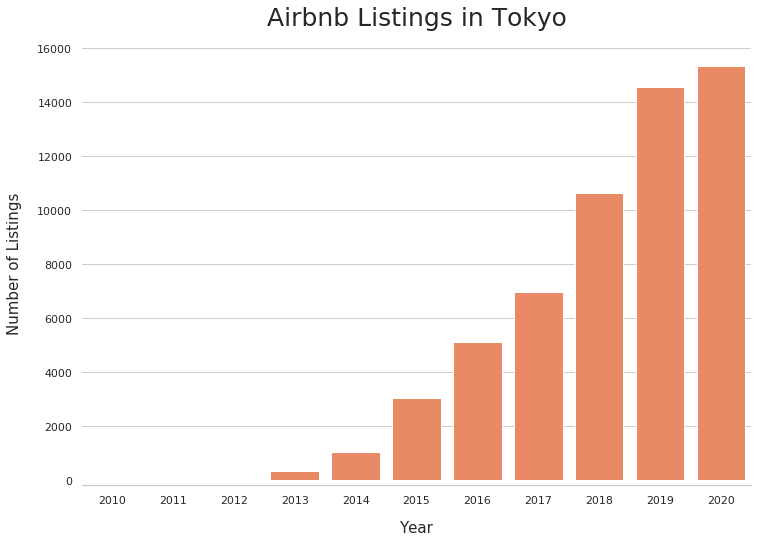

In [20]:
# Price is in string format with '$'' and ','' Remove and convert to float
listings.price = listings.price.replace('[\$,]', '', regex=True).astype(float)
# Convert host_since from string to datetime
listings['host_since'] = pd.to_datetime(listings['host_since'])
# Create a series to group listings by year and convert to a dataframe
result = listings.groupby(listings['host_since'].map(lambda x: x.year)).id.count()
year = pd.DataFrame(result)
# Rename column id to listings and reset index
year.rename(columns={'id':'listings'}, inplace=True)
year = pd.DataFrame(year).reset_index()
# Create a new column with the cumulative listings by year
year['total listings']= year['listings'].cumsum(axis=0)
# Convert host_since data type to int
year['host_since'] = year['host_since'].astype(int)
# Rename column host_since to year
year.rename(columns={'host_since':'year'}, inplace=True)
# Plot Airbnb listings over time
sns.set(style="whitegrid")
fig, ax = plt.subplots()
fig.set_size_inches(12, 8)
ax = sns.barplot(x="year", y="total listings", data=year, color='Coral')
ax.set_title('Airbnb Listings in Tokyo',fontsize=25,pad=20) # Give the plot a main title
ax.set_xlabel('Year',fontsize=15, labelpad=15) # Set text for the x axis,
ax.set_ylabel('Number of Listings',fontsize=15, labelpad=15)# Set text for y axis  
sns.despine(offset=5, left=True)

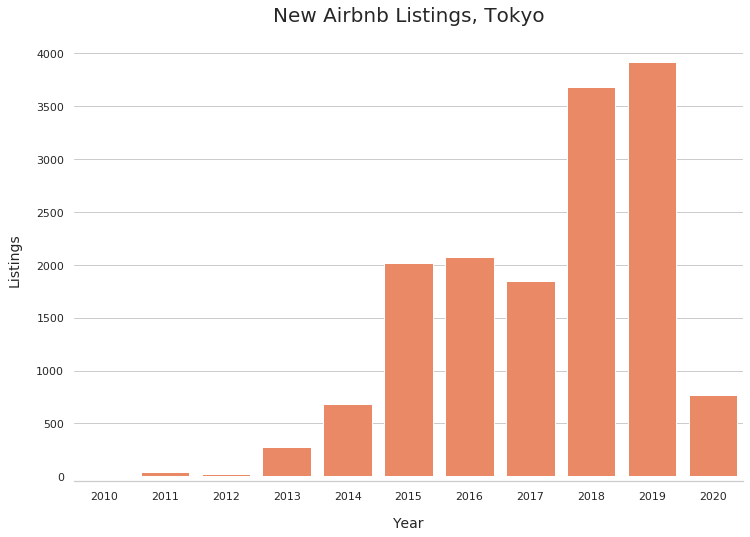

In [21]:
# Plot new Airbnb listings over time
sns.set(style="whitegrid")
fig, ax = plt.subplots()
fig.set_size_inches(12, 8)
ax = sns.barplot(x='year', y="listings", data=year, color="coral")
ax.set_title('New Airbnb Listings, Tokyo',fontsize=20,pad=20) # Give the plot a main title
ax.set_xlabel('Year',fontsize=14, labelpad=15) # Set text for the x axis,
ax.set_ylabel('Listings',fontsize=14, labelpad=15)# Set text for y axis  
sns.despine(offset=5, left=True)